'<div align="center">**Predicting Players with what Kind of Experience Level would Contribute the Most Playing Data to our Game**</div>'

**Introduction**

- provide some relevant background information on the topic so that someone unfamiliar with it will be prepared to understand the rest of your report?

- The Question we tried to answer with our model is which "kinds" of players are most likely to contribute a large amount of data to target those players in our recruiting efforts.

In [75]:
import pandas as pd
import altair as alt 

import altair as alt
import numpy as np
import pandas as pd
from sklearn import set_config
from sklearn.compose import make_column_transformer
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_validate,
    train_test_split,
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV


# Simplify working with large datasets in Altair
alt.data_transformers.enable('vegafusion')

# Output dataframes instead of arrays
set_config(transform_output="pandas")

np.random.seed(2000)

from sklearn.metrics import recall_score, precision_score

In [76]:
players = pd.read_csv("data/players.csv")
players

,experience,subscribe,hashedEmail,played_hours,name,gender,age,individualId,organizationName
0,Pro,True,f6daba428a5e19a3d47574858c13550499be23603422e6...,30.3,Morgan,Male,9,NaN,NaN
1,Veteran,True,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa9397...,3.8,Christian,Male,17,NaN,NaN
2,Veteran,False,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3...,0.0,Blake,Male,17,NaN,NaN
3,Amateur,True,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4f...,0.7,Flora,Female,21,NaN,NaN
4,Regular,True,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb...,0.1,Kylie,Male,21,NaN,NaN
...,...,...,...,...,...,...,...,...,...
191,Amateur,True,b6e9e593b9ec51c5e335457341c324c34a2239531e1890...,0.0,Bailey,Female,17,NaN,NaN
192,Veteran,False,71453e425f07d10da4fa2b349c83e73ccdf0fb3312f778...,0.3,Pascal,Male,22,NaN,NaN
193,Amateur,False,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db29...,0.0,Dylan,Prefer not to say,17,NaN,NaN
194,Amateur,False,f19e136ddde68f365afc860c725ccff54307dedd13968e...,2.3,Harlow,Male,17,NaN,NaN


In [77]:
num_observations = players.shape[0]
num_observations

196

In [78]:
num_variables = players.shape[1]
num_variables

9

In [79]:
data_description = pd.DataFrame({
    "Variable": ["experience", "subscribe", "hashedEmail", "played_hours", "name", "gender", "age", "individualId", "organizationName"],
    "Type": ["Categorical", "Boolean", "String", "Float", "String", "Categorical", "Integer", "Integer", "String"],
    "Description": [
        "The player's level of experience.",
        "Whether the player has subscribed to the service (True or False).",
        "The hashed email of the player.",
        "The number of hours the player has spent in the game.",
        "The name of the player.",
        "The gender of the player .",
        "The age of the player in years.",
        "Unique identifier of the player.",
        "Name of the organization the player is affiliated with."
    ],
    "Potential Issues": [
        "Some categories may have too few observations, making analysis challenging.",
        "Boolean value might have missing data or misinterpretation issues.",
        "The email is hashed, so it cannot be used for personal identification.",
        "Some values may be zero or unusually high, suggesting data entry errors or outliers.",
        "...",
        "Some entries may lack gender data.",
        "Age may contain outliers.",
        "Values are missing from the dataset.",
        "Values are missing from the dataset."
    ],
    "Potential Issues (cannot see)": [
        "Players are self-reporting so they could be reporting wrong experience.",
        "Many people who have a subscription may not even check their emails for updates.",
        "People could be entering the wrong email so we may not have a way to contact the player.",
        "...",
        "Players could be using nicknames which makes identification harder.",
        "Gender data could be inaccurate due to self-reporting.",
        "Age may be entered incorrectly on purpose.",
        "...",
        "...",
    ]
})

styled_table = data_description.style.set_properties(
    **{'text-align': 'center'}
).set_table_styles(
    [{'selector': 'th', 'props': [('text-align', 'center')]}]
)

styled_table

,Variable,Type,Description,Potential Issues,Potential Issues (cannot see)
0,experience,Categorical,The player's level of experience.,"Some categories may have too few observations, making analysis challenging.",Players are self-reporting so they could be reporting wrong experience.
1,subscribe,Boolean,Whether the player has subscribed to the service (True or False).,Boolean value might have missing data or misinterpretation issues.,Many people who have a subscription may not even check their emails for updates.
2,hashedEmail,String,The hashed email of the player.,"The email is hashed, so it cannot be used for personal identification.",People could be entering the wrong email so we may not have a way to contact the player.
3,played_hours,Float,The number of hours the player has spent in the game.,"Some values may be zero or unusually high, suggesting data entry errors or outliers.",...
4,name,String,The name of the player.,...,Players could be using nicknames which makes identification harder.
5,gender,Categorical,The gender of the player .,Some entries may lack gender data.,Gender data could be inaccurate due to self-reporting.
6,age,Integer,The age of the player in years.,Age may contain outliers.,Age may be entered incorrectly on purpose.
7,individualId,Integer,Unique identifier of the player.,Values are missing from the dataset.,...
8,organizationName,String,Name of the organization the player is affiliated with.,Values are missing from the dataset.,...


**Methods and Results**

In [80]:
players.head(5)

,experience,subscribe,hashedEmail,played_hours,name,gender,age,individualId,organizationName
0,Pro,True,f6daba428a5e19a3d47574858c13550499be23603422e6...,30.3,Morgan,Male,9,NaN,NaN
1,Veteran,True,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa9397...,3.8,Christian,Male,17,NaN,NaN
2,Veteran,False,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3...,0.0,Blake,Male,17,NaN,NaN
3,Amateur,True,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4f...,0.7,Flora,Female,21,NaN,NaN
4,Regular,True,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb...,0.1,Kylie,Male,21,NaN,NaN


In [81]:
# data wrangling 

# change experience labels to numerical values 
players["experience_encode"] = players["experience"].replace({
#    "Beginner" : 1,
    "Regular" : 2, 
    "Amateur" : 3, 
    "Veteran" : 4, 
    "Pro": 5,
})

players["subscribe_encode"] = players["subscribe"].astype(int)


# we wouldnt need to do this !!

# select three rows
players_wrangled = players[["experience", "experience_encode","played_hours", "age", "subscribe", "subscribe_encode", "gender"]]
#players_wrangled = players[["played_hours", "age", "subscribe", "subscribe_encode"]]
players_wrangled 

,experience,experience_encode,played_hours,age,subscribe,subscribe_encode,gender
0,Pro,5,30.3,9,True,1,Male
1,Veteran,4,3.8,17,True,1,Male
2,Veteran,4,0.0,17,False,0,Male
3,Amateur,3,0.7,21,True,1,Female
4,Regular,2,0.1,21,True,1,Male
...,...,...,...,...,...,...,...
191,Amateur,3,0.0,17,True,1,Female
192,Veteran,4,0.3,22,False,0,Male
193,Amateur,3,0.0,17,False,0,Prefer not to say
194,Amateur,3,2.3,17,False,0,Male


In [82]:
players_wrangled_more = players_wrangled.assign(age_squared = players_wrangled['age']**2,
                                                log_age=np.log(players_wrangled['age']),
                                                sin_age=np.sin(players_wrangled['age']))
players_wrangled_more

,experience,experience_encode,played_hours,age,subscribe,subscribe_encode,gender,age_squared,log_age,sin_age
0,Pro,5,30.3,9,True,1,Male,81,2.197225,0.412118
1,Veteran,4,3.8,17,True,1,Male,289,2.833213,-0.961397
2,Veteran,4,0.0,17,False,0,Male,289,2.833213,-0.961397
3,Amateur,3,0.7,21,True,1,Female,441,3.044522,0.836656
4,Regular,2,0.1,21,True,1,Male,441,3.044522,0.836656
...,...,...,...,...,...,...,...,...,...,...
191,Amateur,3,0.0,17,True,1,Female,289,2.833213,-0.961397
192,Veteran,4,0.3,22,False,0,Male,484,3.091042,-0.008851
193,Amateur,3,0.0,17,False,0,Prefer not to say,289,2.833213,-0.961397
194,Amateur,3,2.3,17,False,0,Male,289,2.833213,-0.961397


In [83]:
# General overview
players_wrangled.shape

(196, 7)

In [84]:
players_wrangled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196 entries, 0 to 195
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   experience         196 non-null    object 
 1   experience_encode  196 non-null    object 
 2   played_hours       196 non-null    float64
 3   age                196 non-null    int64  
 4   subscribe          196 non-null    bool   
 5   subscribe_encode   196 non-null    int64  
 6   gender             196 non-null    object 
dtypes: bool(1), float64(1), int64(2), object(3)
memory usage: 9.5+ KB


In [85]:
players_wrangled.describe()

,played_hours,age,subscribe_encode
count,196.000000,196.000000,196.000000
mean,5.845918,21.280612,0.734694
std,28.357343,9.706346,0.442627
min,0.000000,8.000000,0.000000
25%,0.000000,17.000000,0.000000
50%,0.100000,19.000000,1.000000
75%,0.600000,22.000000,1.000000
max,223.100000,99.000000,1.000000


In [86]:
players_wrangled['experience'].value_counts()

experience
Amateur     63
Veteran     48
Regular     36
Beginner    35
Pro         14
Name: count, dtype: int64

In [87]:
players_wrangled['subscribe'].value_counts()

subscribe
True     144
False     52
Name: count, dtype: int64

In [88]:
players_wrangled['gender'].value_counts()

gender
Male                 124
Female                37
Non-binary            15
Prefer not to say     11
Two-Spirited           6
Agender                2
Other                  1
Name: count, dtype: int64

In [89]:
players_wrangled.isnull().sum()

experience           0
experience_encode    0
played_hours         0
age                  0
subscribe            0
subscribe_encode     0
gender               0
dtype: int64

In [90]:
players_plot = alt.Chart(players_wrangled).mark_circle().encode(
    x=alt.X("age").title("Age (years)"),
    y=alt.Y("played_hours").title("Played Hours"),
    color=alt.Color("experience").title("Experience Level")
)

players_plot

alt.Chart(...)

**Figure 1: Scatter plot showing the relationship between age and hours played color-coded to show the experience level of the players**

In [91]:
players_plot = alt.Chart(players_wrangled).mark_bar().encode(
    x=alt.X("subscribe_encode").title("Subsribe"),
    y=alt.Y("played_hours").title("Played Hours"),
    color=alt.Color("experience").title("Experience Level")
)

players_plot

alt.Chart(...)

**Figure 2: Scatter plot showing the relationship between subscribed and hours played color-coded to show the experience level of the players**

In [92]:
players_plot = alt.Chart(players_wrangled).mark_circle().encode(
    x=alt.X("experience").title("Experience"),
    y=alt.Y("played_hours").title("Played Hours"),
    color=alt.Color("experience").title("Experience Level")
)

players_plot

alt.Chart(...)

In [93]:
players_plot = alt.Chart(players_wrangled).mark_circle().encode(
    x=alt.X("gender").title("Gender"),
    y=alt.Y("played_hours").title("Played Hours"),
    color=alt.Color("experience").title("Experience Level")
)

players_plot

alt.Chart(...)

In [94]:
players_plot = alt.Chart(players_wrangled_more).mark_circle().encode(
    x=alt.X("age_squared").title("Age Squared"),
    y=alt.Y("played_hours").title("Played Hours"),
    color=alt.Color("experience").title("Experience Level")
)

players_plot

alt.Chart(...)

In [95]:
players_plot = alt.Chart(players_wrangled_more).mark_circle().encode(
    x=alt.X("sin_age").title("Sin of Age"),
    y=alt.Y("played_hours").title("Played Hours"),
    color=alt.Color("experience").title("Experience Level")
)

players_plot

alt.Chart(...)

In [96]:
players_plot = alt.Chart(players_wrangled_more).mark_circle().encode(
    x=alt.X("log_age").title("Log of Age"),
    y=alt.Y("played_hours").title("Played Hours"),
    color=alt.Color("experience").title("Experience Level")
)

players_plot

alt.Chart(...)

In [100]:
#players_train, players_test = train_test_split(players_wrangled, test_size=0.25, stratify = players_wrangled["gender"], random_state = 123)
players_train, players_test = train_test_split(players_wrangled_more, test_size=0.25, stratify = players_wrangled["experience"], random_state = 123)

#players_preprocessor = make_column_transformer(
#    (StandardScaler(), ["age", "played_hours"]),
#    verbose_feature_names_out=False
#)


#pre processor
players_preprocessor = make_column_transformer(
    (StandardScaler(), ["age", "age_squared", "log_age", "sin_age", "played_hours", "subscribe_encode"]),
)


players_scaled = players_preprocessor.fit_transform(players_train)
players_scaled


# players_plot_scaled = alt.Chart(players_scaled).mark_circle().encode(
#     x=alt.X("standardscaler__age").title("Age in Years (Standardized)").scale(zero = False),
#     y=alt.Y("standardscaler__played_hours").title("Played Hours(Standardized)").scale(zero = False),
#    # color=alt.Color("experience").title("Experience Level")
# )

# players_plot_scaled

,standardscaler__age,standardscaler__age_squared,standardscaler__log_age,standardscaler__sin_age,standardscaler__played_hours,standardscaler__subscribe_encode
99,-1.035241,-0.465698,-1.794907,-0.304809,-0.152896,0.611418
86,0.173412,-0.014895,0.418631,-0.719107,-0.184696,-1.635543
32,-0.485853,-0.295915,-0.609840,-0.873211,-0.184696,0.611418
20,-1.474751,-0.559371,-3.174448,1.736841,-0.165616,0.611418
111,-0.046343,-0.117936,0.109111,1.532529,0.069699,0.611418
...,...,...,...,...,...,...
5,-0.485853,-0.295915,-0.609840,-0.873211,-0.184696,0.611418
73,0.063535,-0.067587,0.267389,0.401267,-0.184696,0.611418
156,0.173412,-0.014895,0.418631,-0.719107,-0.178336,0.611418
102,0.283290,0.040138,0.563434,-0.798527,-0.184696,0.611418


In [101]:
X_train = players_train[["age", "age_squared", "log_age", "sin_age", "played_hours", "subscribe_encode"]]
y_train = players_train["experience"]

#knn = KNeighborsClassifier(n_neighbors=3)

#knn_pipeline = make_pipeline(players_preprocessor, knn)
#knn_pipeline.fit(X_train, y_train)

#knn_pipeline


# players_test["predicted"] = knn_pipeline.predict(players_test[["age", "played_hours"]])
# players_test.head()

In [102]:
#knn_pipeline.score(
#    players_test[["age", "played_hours"]],
#    players_test["experience"]
#)

## accuracy

In [103]:
knn = KNeighborsClassifier()
players_tune_pipe = make_pipeline(players_preprocessor, knn)



param_grid = {
    "kneighborsclassifier__n_neighbors": range(1, 18, 1),
}


In [104]:
players_tune_grid = GridSearchCV(
    estimator=players_tune_pipe,
    param_grid=param_grid,
    cv=5
)

players_tune_grid.fit(X_train, y_train)

accuracies_grid = pd.DataFrame(players_tune_grid.cv_results_)

In [105]:
accuracies_grid["sem_test_score"] = accuracies_grid["std_test_score"] / 10**(1/2)
accuracies_grid = (
    accuracies_grid[[
        "param_kneighborsclassifier__n_neighbors",
        "mean_test_score",
        "sem_test_score"
    ]]
    .rename(columns={"param_kneighborsclassifier__n_neighbors": "n_neighbors"})
)

accuracies_grid.reset_index()

,index,n_neighbors,mean_test_score,sem_test_score
0,0,1,0.272184,0.012030
1,1,2,0.367816,0.013793
2,2,3,0.292644,0.016449
3,3,4,0.320460,0.018664
4,4,5,0.292644,0.019863
5,5,6,0.306437,0.018485
6,6,7,0.292644,0.011308
7,7,8,0.299310,0.012468
8,8,9,0.319770,0.014760
9,9,10,0.265517,0.008644


In [106]:
accuracies_grid = pd.DataFrame(players_tune_grid.cv_results_)

In [107]:
accuracies_grid["sem_test_score"] = accuracies_grid["std_test_score"] / 10**(1/2)
accuracies_grid = (
    accuracies_grid[[
        "param_kneighborsclassifier__n_neighbors",
        "mean_test_score",
        "sem_test_score"
    ]]
    .rename(columns={"param_kneighborsclassifier__n_neighbors": "n_neighbors"})
)
accuracies_grid

,n_neighbors,mean_test_score,sem_test_score
0,1,0.272184,0.012030
1,2,0.367816,0.013793
2,3,0.292644,0.016449
3,4,0.320460,0.018664
4,5,0.292644,0.019863
5,6,0.306437,0.018485
6,7,0.292644,0.011308
7,8,0.299310,0.012468
8,9,0.319770,0.014760
9,10,0.265517,0.008644


In [108]:
accuracy_vs_k = alt.Chart(accuracies_grid).mark_line(point=True).encode(
    x=alt.X("n_neighbors").title("Neighbors"),
    y=alt.Y("mean_test_score")
        .scale(zero=False)
        .title("Accuracy estimate")
)

accuracy_vs_k

alt.Chart(...)

**Figure 3: Plot showing the relationship K Neighnors and accuracy value we would acheive in our model**

In [109]:
players_tune_grid.best_params_

{'kneighborsclassifier__n_neighbors': 2}

In [111]:
# players_test = players_test.assign(
#     predicted = players_tune_pipe.predict(players_test[["age", "played_hours"]])
# ).reset_index()

players_test["predicted"] = players_tune_grid.predict(
    players_test[["age", "age_squared", "log_age", "sin_age", "played_hours", "subscribe_encode"]]
)

players_test.head()

,experience,experience_encode,played_hours,age,subscribe,subscribe_encode,gender,age_squared,log_age,sin_age,predicted
104,Amateur,3,0.0,26,False,0,Two-Spirited,676,3.258097,0.762558,Amateur
44,Veteran,4,2.2,24,True,1,Male,576,3.178054,-0.905578,Amateur
100,Amateur,3,0.0,20,True,1,Male,400,2.995732,0.912945,Amateur
121,Beginner,Beginner,0.1,24,True,1,Male,576,3.178054,-0.905578,Beginner
49,Beginner,Beginner,0.4,22,True,1,Prefer not to say,484,3.091042,-0.008851,Amateur


In [113]:
players_prediction_accuracy = players_tune_grid.score(
    players_test[["age", "age_squared", "log_age", "sin_age", "played_hours", "subscribe_encode"]],
    players_test["experience"]
)

players_prediction_accuracy

0.2653061224489796

In [114]:
players_mat = pd.crosstab(
    players_test["gender"],  # True labels
    players_test["predicted"],  # Predicted labels
)

players_mat

predicted,Amateur,Beginner,Pro,Regular,Veteran
gender,,,,,
Female,5,2,0,0,0
Male,24,3,1,3,1
Non-binary,3,2,0,0,0
Other,0,0,0,1,0
Prefer not to say,3,0,0,0,0
Two-Spirited,1,0,0,0,0


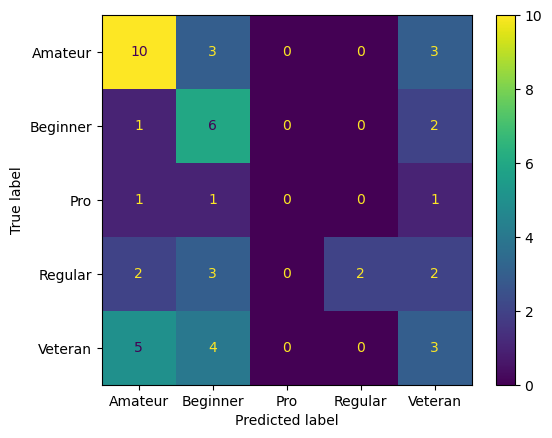

In [116]:
from sklearn.metrics import ConfusionMatrixDisplay

X_test = players_test[["age", "age_squared", "log_age", "sin_age", "played_hours", "subscribe_encode"]]
y_test = players_test["experience"]

players_tune_pipe.fit(X_test, y_test)


ConfusionMatrixDisplay.from_estimator(
    players_tune_pipe,  # We are directly passing the pipeline and let sklearn do the predictions for us
    X_test,
    y_test
)

**Figure 4: Confusion matrix showing the performance of the classification model, with true positive, false positive, true negative, and false negative values**

In [124]:
test_data = pd.DataFrame({
    "age": np.random.randint(0, 60, 5),  # Random ages between 18 and 60
    "age_squared": np.random.randint(0, 2000, 5),
    "log_age": np.random.randint(0, 5, 5),
    "sin_age": np.random.randint(-1, 1, 5),
    "played_hours": np.random.randint(0, 200, 5),  # Random played hours between 100 and 2000
    "subscribe_encode": np.random.choice([0, 1], 5),  # Random subscription status (0 or 1)
    
})

# Predict gender (since the model was trained to predict gender)
players_tune_grid.predict(test_data)

array(['Amateur', 'Amateur', 'Regular', 'Pro', 'Pro'], dtype=object)

In [125]:
#test_data1 = pd.DataFrame({
#    "age": [23],  # Random ages between 18 and 60
#    "played_hours": [150],  # Random played hours between 100 and 2000
#    "subscribe_encode": [0],  # Random subscription status (0 or 1)
#})

# Predict gender (since the model was trained to predict gender)
#players_tune_grid.predict(test_data1)

**Discussion**